In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # To suppress the seaborn warnings

--------------------------------------
# **Section 1: Eval_env**

In [2]:
def generate_stat(folder, eval_quantiles, fig, agent_name):
  eval_df = pd.read_csv(folder)
  eval_loop_df = eval_df[['episode','step_pnl']].groupby('episode').aggregate('sum')
  eval_loop_df.columns = ['episode_return']
  gamma_exposure_df = eval_df[['episode','gamma_before_hedge', 'gamma_after_hedge']]
  gamma_exposure_df['gamma_hedged_amount'] = (gamma_exposure_df['gamma_before_hedge']-gamma_exposure_df['gamma_after_hedge'])*np.sign(gamma_exposure_df['gamma_before_hedge'])
  gamma_exposure_df['gamma_before_hedge_level'] = gamma_exposure_df['gamma_before_hedge'].abs()
  gamma_exposure_df = gamma_exposure_df.groupby('episode').aggregate('sum')
  gamma_exposure = gamma_exposure_df['gamma_hedged_amount']/gamma_exposure_df['gamma_before_hedge_level']

  vega_exposure_df = eval_df[['episode','vega_before_hedge', 'vega_after_hedge']]
  vega_exposure_df['vega_hedged_amount'] = (vega_exposure_df['vega_before_hedge']-vega_exposure_df['vega_after_hedge'])*np.sign(vega_exposure_df['vega_before_hedge'])
  vega_exposure_df['vega_before_hedge_level'] = vega_exposure_df['vega_before_hedge'].abs()
  vega_exposure_df = vega_exposure_df.groupby('episode').aggregate('sum')
  vega_exposure = vega_exposure_df['vega_hedged_amount']/vega_exposure_df['vega_before_hedge_level']

  pnl_mean = eval_loop_df['episode_return'].mean()
  pnl_std = eval_loop_df['episode_return'].std()
  Mean_Std = pnl_mean-1.645*pnl_std

  gamma_ratio = gamma_exposure.mean()
  gamma_ratio_10 = gamma_exposure.quantile(0.10)
  gamma_ratio_90 = gamma_exposure.quantile(0.90)

  vega_ratio = vega_exposure.mean()
  vega_ratio_10 = vega_exposure.quantile(0.10)
  vega_ratio_90 = vega_exposure.quantile(0.90)

  stats_str = f"""{agent_name: <14}: pnl mean: {pnl_mean:.2f} | std: {pnl_std:.6f} 
                Mean-SD: {Mean_Std:.2f} | gamma-ratio: {gamma_ratio:5.2f}({gamma_ratio_10:5.2f}/{gamma_ratio_90:5.2f}) 
                vega-ratio: {vega_ratio:5.2f}({vega_ratio_10:5.2f}/{vega_ratio_90:5.2f})"""

  for q in eval_quantiles:
    stats_str += f"""
                var_{100*q:.0f}: {eval_loop_df["episode_return"].quantile(1-q):8.2f}"""

  for q in eval_quantiles:
    _cvar = eval_loop_df.loc[eval_loop_df['episode_return']<=eval_loop_df['episode_return'].quantile(1-q),'episode_return'].mean()
    stats_str += f"""
                cvar_{100*q:.0f}: {_cvar:8.2f} """
    
  print(stats_str)
  fig.add_trace(go.Histogram(
      x=eval_loop_df.episode_return.values,
      histnorm='percent', name=f'{agent_name} Terminal P&L', opacity=0.75,
      nbinsx=250
  ))
  fig.update_layout(title_text=f'{agent_name} Terminal P&L')
  fig.update_layout(hovermode="x")

  return eval_loop_df.episode_return.values

def EDA_on_eval_log_file(eval_log_loc, save_plot=False):
    logs_data = pd.read_csv(eval_log_loc)
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 12))

    # 1. Distribution of gamma exposures before and after hedging
    plt.subplot(2, 3, 1)
    sns.histplot(logs_data['gamma_before_hedge'], color="blue", label='Gamma Before Hedging', kde=True)
    sns.histplot(logs_data['gamma_after_hedge'], color="red", label='Gamma After Hedging', kde=True)
    plt.title('Distribution of Gamma Before and After Hedging')
    plt.legend()

    # 2. Distribution of vega exposures before and after hedging
    plt.subplot(2, 3, 2)
    sns.histplot(logs_data['vega_before_hedge'], color="blue", label='Vega Before Hedging', kde=True)
    sns.histplot(logs_data['vega_after_hedge'], color="red", label='Vega After Hedging', kde=True)
    plt.title('Distribution of Vega Before and After Hedging')
    plt.legend()

    # 3. Time series of stock prices
    plt.subplot(2, 3, 3)
    sns.lineplot(data=logs_data, x='t', y='stock_price', label='Stock Price')
    sns.lineplot(data=logs_data, x='t', y='state_price', label='State Price')
    plt.title('Time Series of Stock and State Prices')
    plt.legend()

    # 4. Time series of hedging costs
    plt.subplot(2, 3, 4)
    sns.lineplot(data=logs_data, x='t', y='hed_cost')
    plt.title('Time Series of Hedging Costs')

    # 5. Scatter plot of gamma and vega before hedging
    plt.subplot(2, 3, 5)
    sns.scatterplot(x='gamma_before_hedge', y='vega_before_hedge', data=logs_data)
    plt.title('Relationship Between Gamma and Vega Before Hedging')

    # 6. Scatter plot of gamma and vega after hedging
    plt.subplot(2, 3, 6)
    sns.scatterplot(x='gamma_after_hedge', y='vega_after_hedge', data=logs_data)
    plt.title('Relationship Between Gamma and Vega After Hedging')

    plt.tight_layout()
    if save_plot: plt.savefig('EDA_on_eval_log_file.pdf')
    plt.show()
    # is save_plot is True, save the plot as a pdf

In [3]:
eval_log_loc_MV   = '/home/atsoskouno/data/storageith2/gamma-vega-hedging-American-Heston/logs/results_meanstd/stochastic_process=GBM_spread=0.005_obj=var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv'
# eval_log_loc_VaR  = 'logs/results var/spread=0.005_obj=var_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
# eval_log_loc_CVaR = 'logs/results cvar/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
fig = go.Figure()

generate_stat(eval_log_loc_MV,    [0.01, 0.05, 0.1], fig, 'Mean-Std')
# generate_stat(eval_log_loc_VaR,   [0.01, 0.05, 0.1], fig, 'VaR')
# generate_stat(eval_log_loc_CVaR,  [0.01, 0.05, 0.1], fig, 'CVaR')
fig.show()

Mean-Std      : pnl mean: -1.58 | std: 5.643704 
                Mean-SD: -10.87 | gamma-ratio:  0.22( 0.08/ 0.38) 
                vega-ratio:  0.05( 0.01/ 0.10)
                var_1:    11.98
                var_5:     3.97
                var_10:     2.20
                cvar_1:    -1.78 
                cvar_5:    -2.14 
                cvar_10:    -2.42 


## **Mean Variance**

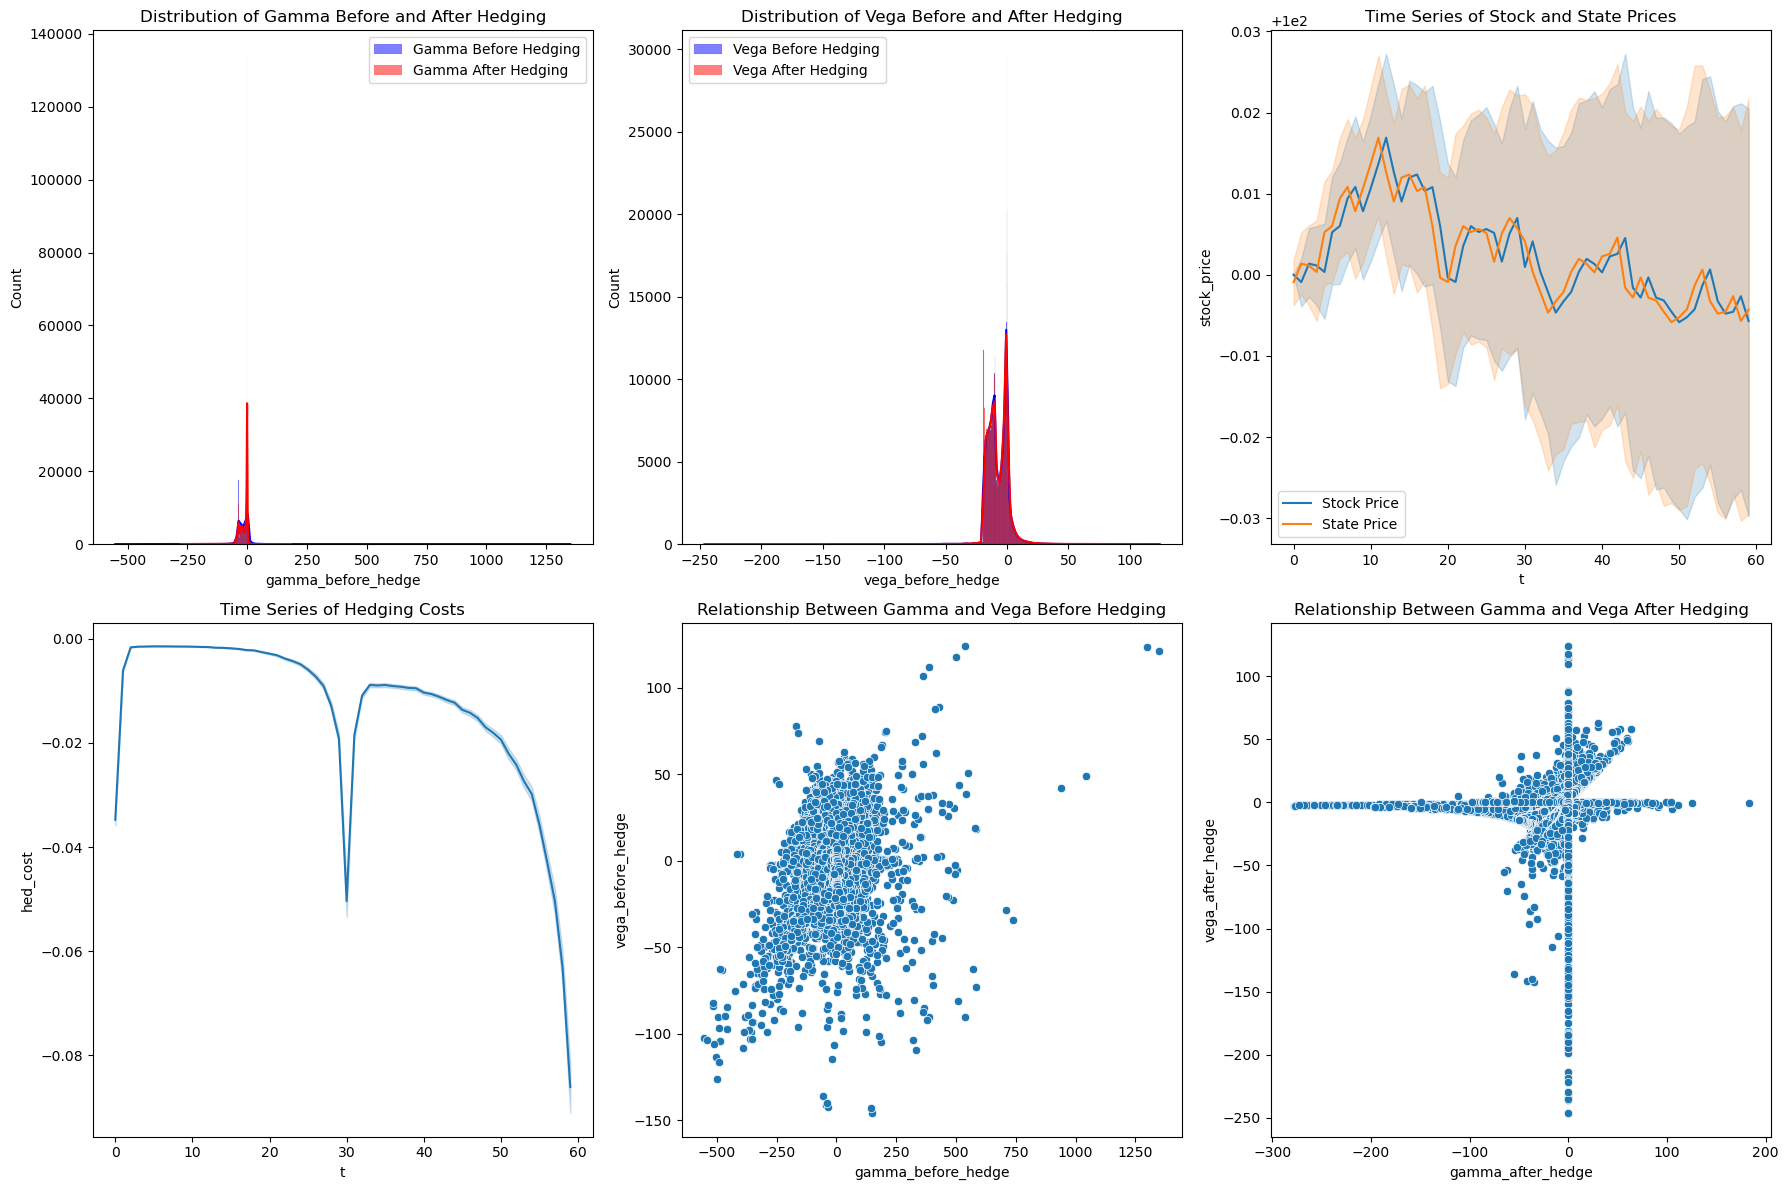

In [4]:
EDA_on_eval_log_file(eval_log_loc_MV, save_plot=True)

## **VaR**

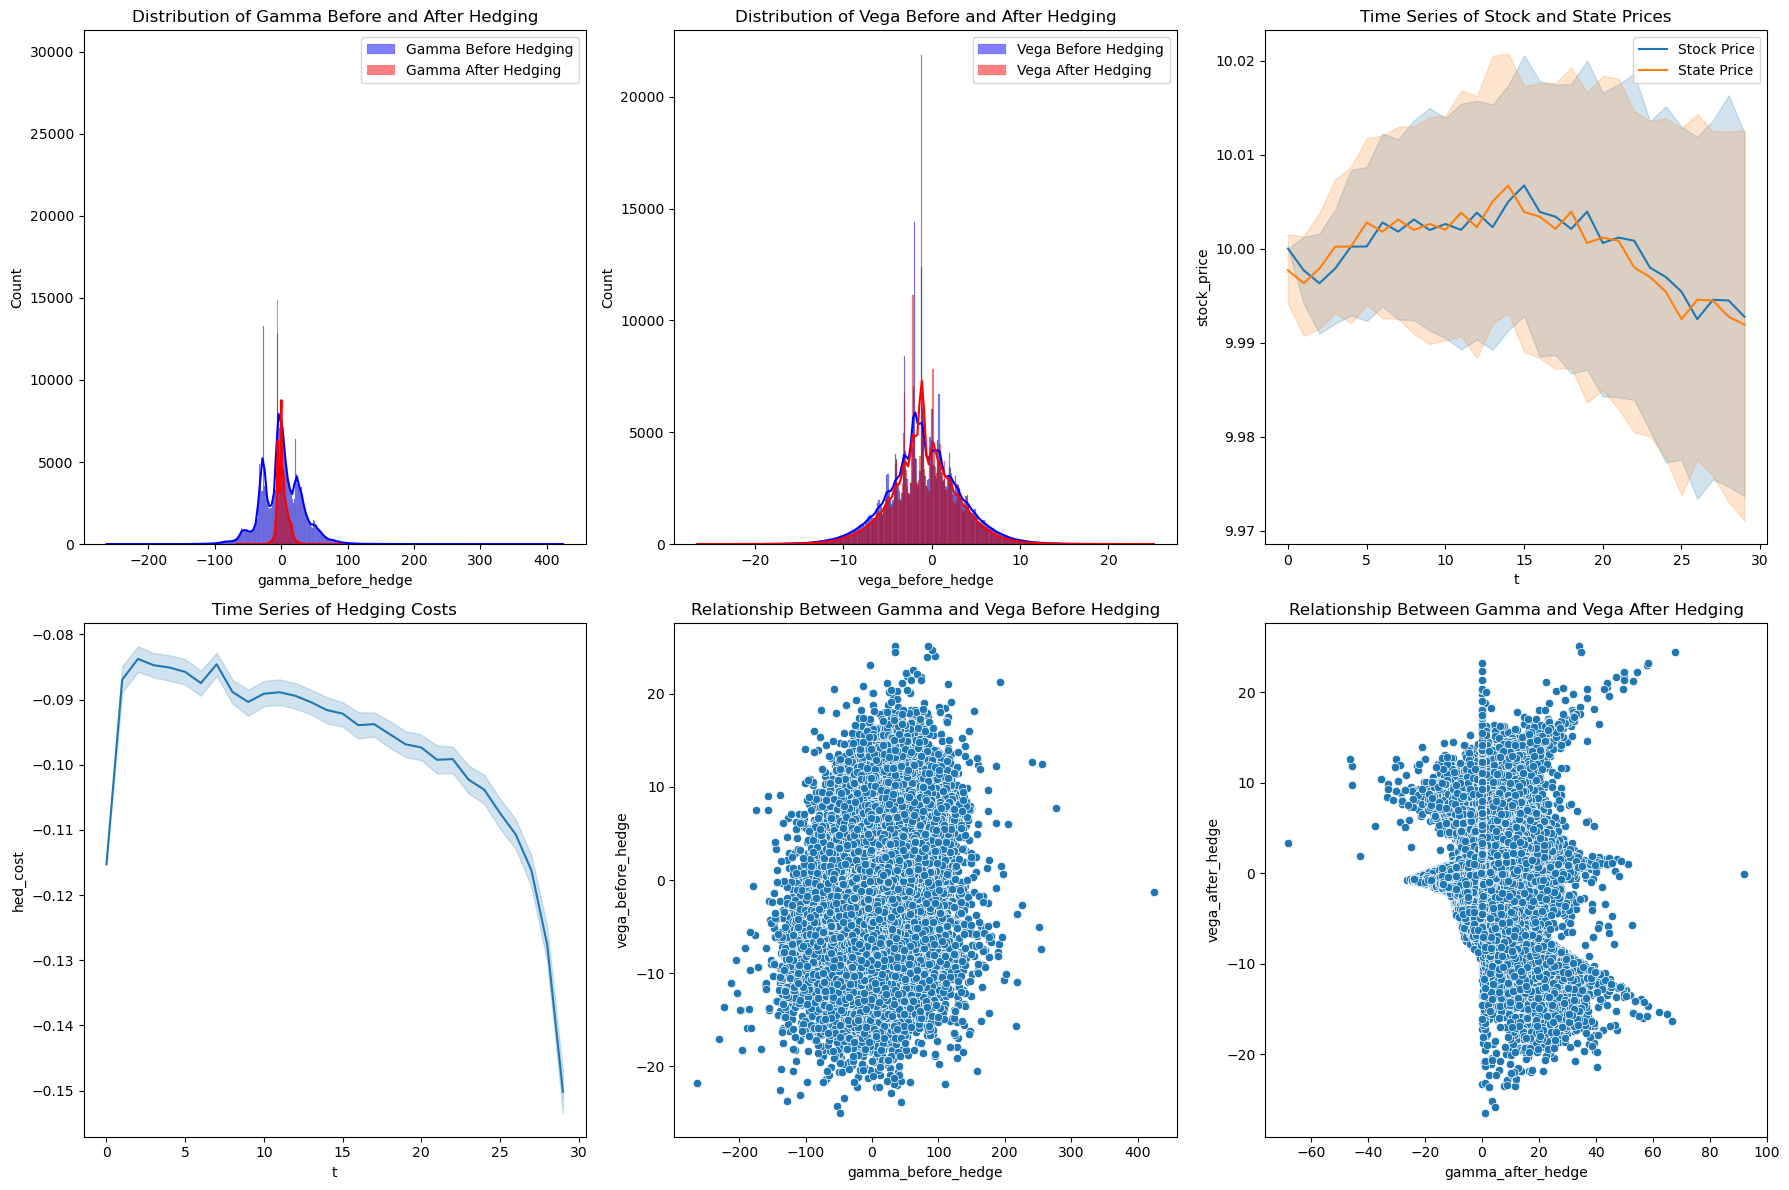

In [7]:
EDA_on_eval_log_file(eval_log_loc_VaR)

## **CVaR**

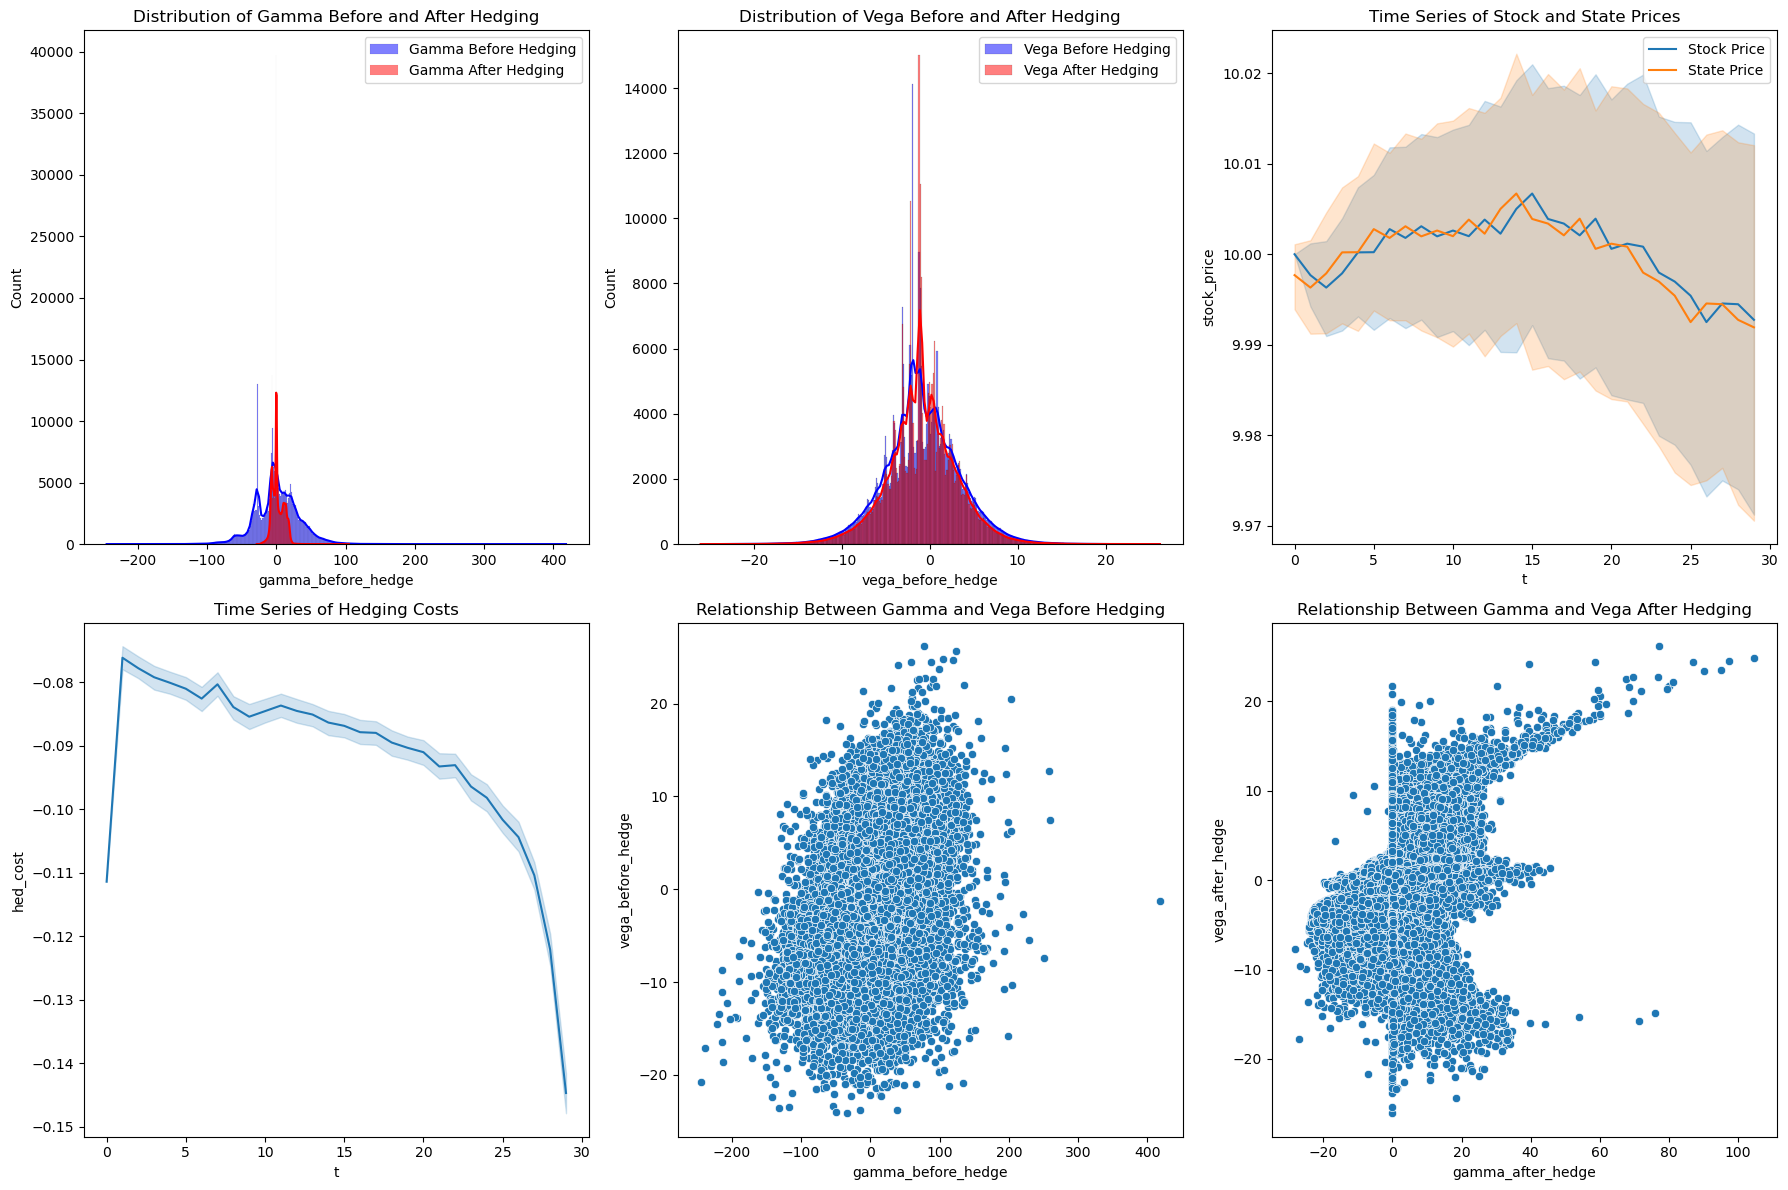

In [10]:
EDA_on_eval_log_file(eval_log_loc_CVaR)

## Average Training and Testing performance

In [14]:
path   = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/results meanstd/spread=0.005_obj=meanstd_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/'
path   = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/results var/spread=0.005_obj=var_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/'
print(f'(Train)Avg Steps Per Second = {pd.read_csv(path + "train_loop/logs.csv").steps_per_second.mean():.2f}')
print(f'(Eval)Avg Steps Per Second = {pd.read_csv(path + "eval_loop/logs.csv").steps_per_second.mean():.2f}')

pd.read_csv(path + "train_loop/logs.csv")

296.30/178.89

(Train)Avg Steps Per Second = 296.30
(Eval)Avg Steps Per Second = 1402.28


1.6563251159930685

------------------------------------------------------------------------------------

In [16]:
eval_log_loc_MV   = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/_results SABR meanstd/spread=0.005_obj=meanstd_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
# eval_log_loc_VaR  = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/results var/spread=0.005_obj=var_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
# eval_log_loc_CVaR = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/results cvar/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
fig = go.Figure()

generate_stat(eval_log_loc_MV,    [0.01, 0.05, 0.1], fig, 'Agent Mean-Std')
# generate_stat(eval_log_loc_VaR,   [0.01, 0.05, 0.1], fig, 'Agent VaR')
# generate_stat(eval_log_loc_CVaR,  [0.01, 0.05, 0.1], fig, 'Agent CVaR')
fig.show()

Agent Mean-Std: pnl mean: -4.43 | std: 10.176049 
                Mean-SD: -21.17 | gamma-ratio:  0.62( 0.26/ 0.98) 
                vega-ratio:  0.22( 0.06/ 0.42)
                var_1:    20.30
                var_5:    10.89
                var_10:     6.61
                cvar_1:    -4.75 
                cvar_5:    -5.58 
                cvar_10:    -6.37 


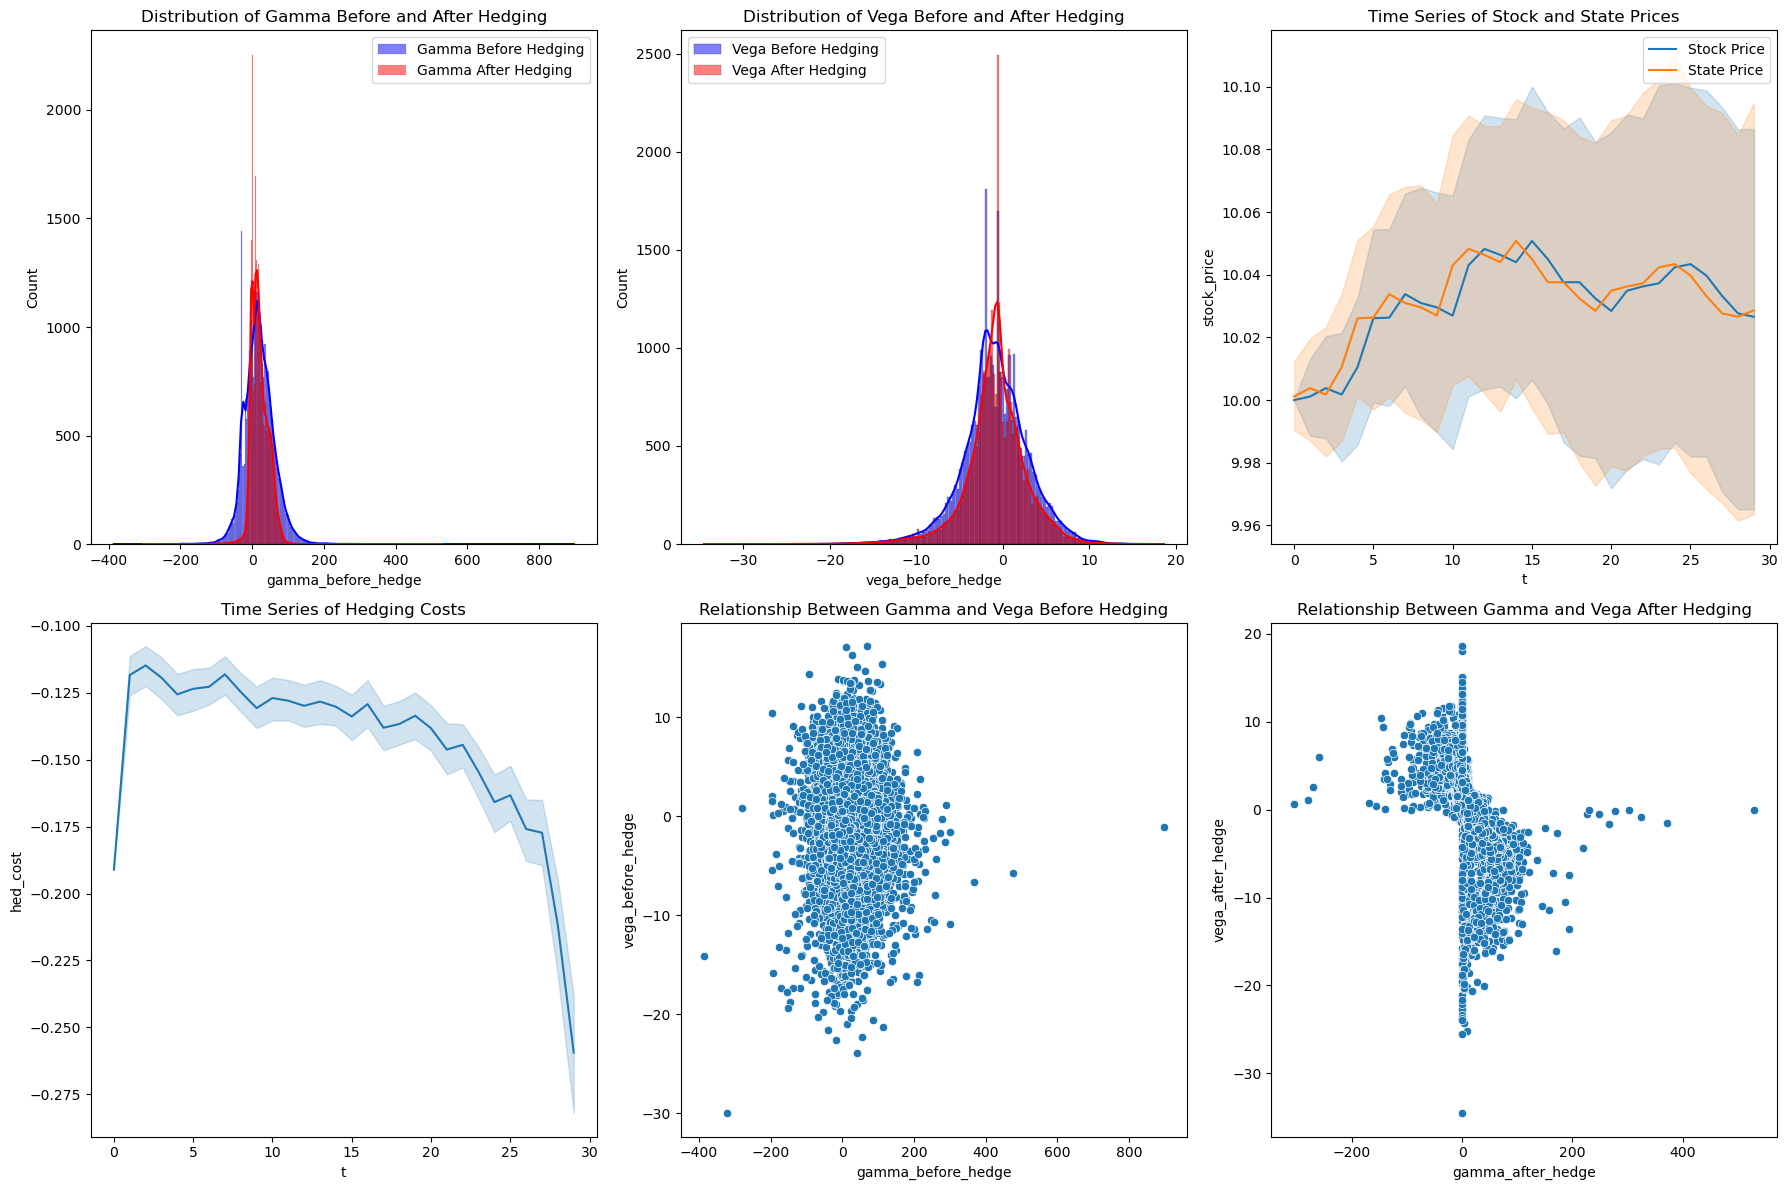

In [17]:
EDA_on_eval_log_file(eval_log_loc_MV)

# **Section 1: Progress Report**

<Axes: title={'center': 'Episode Return MASTD'}, xlabel='episodes'>

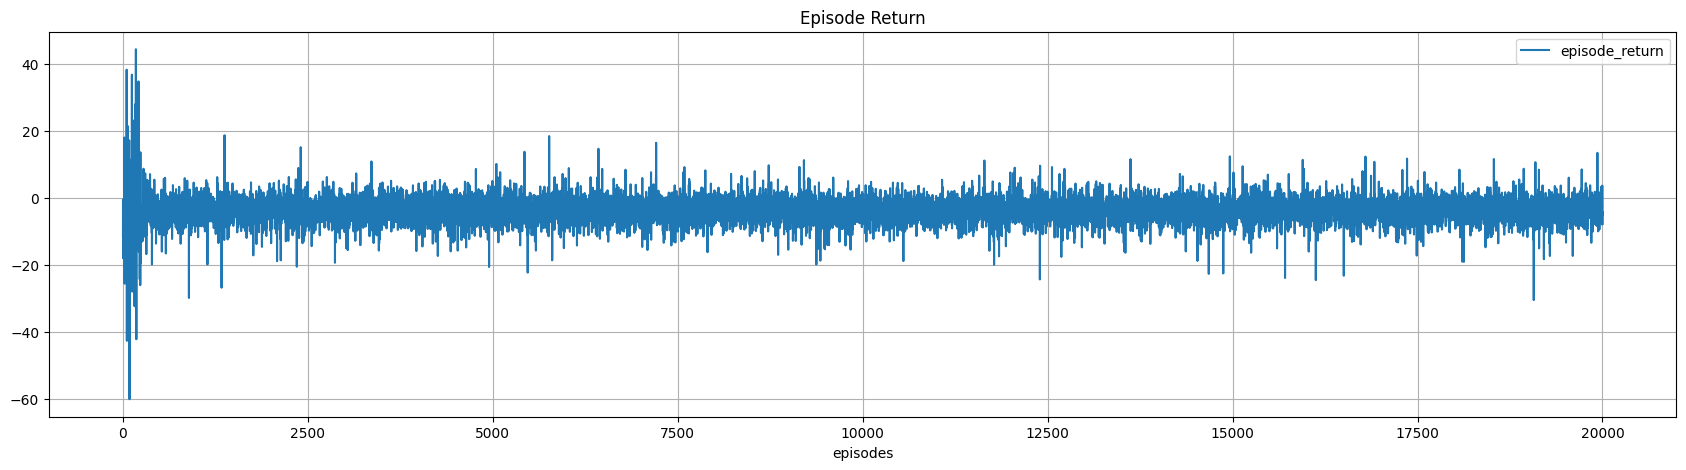

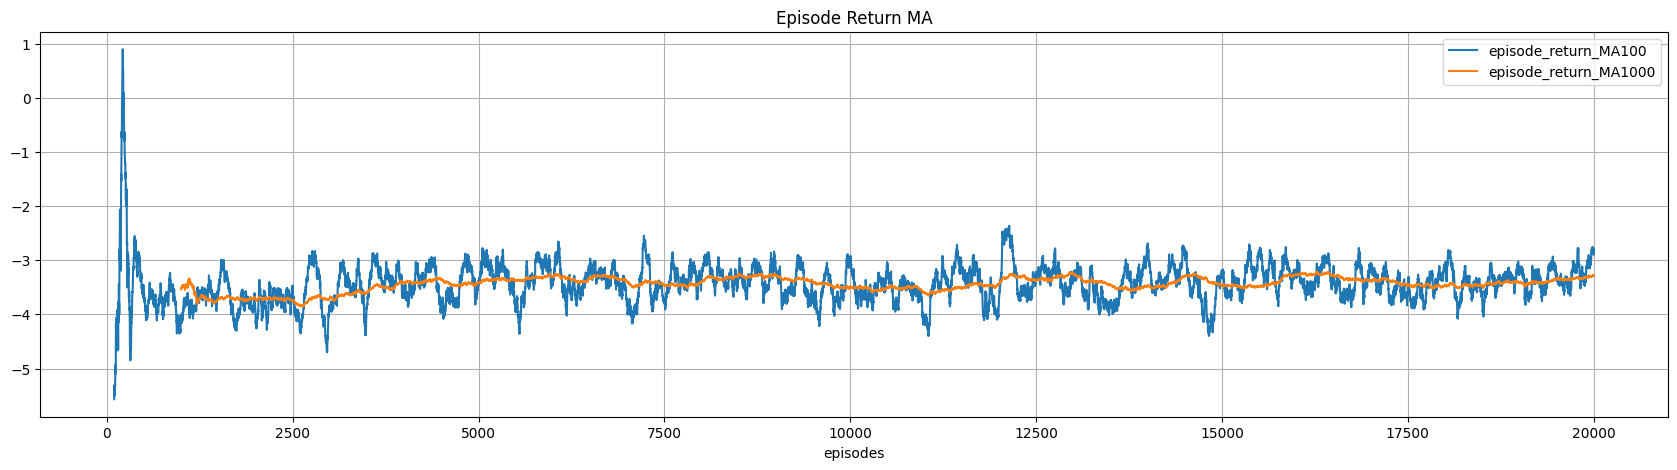

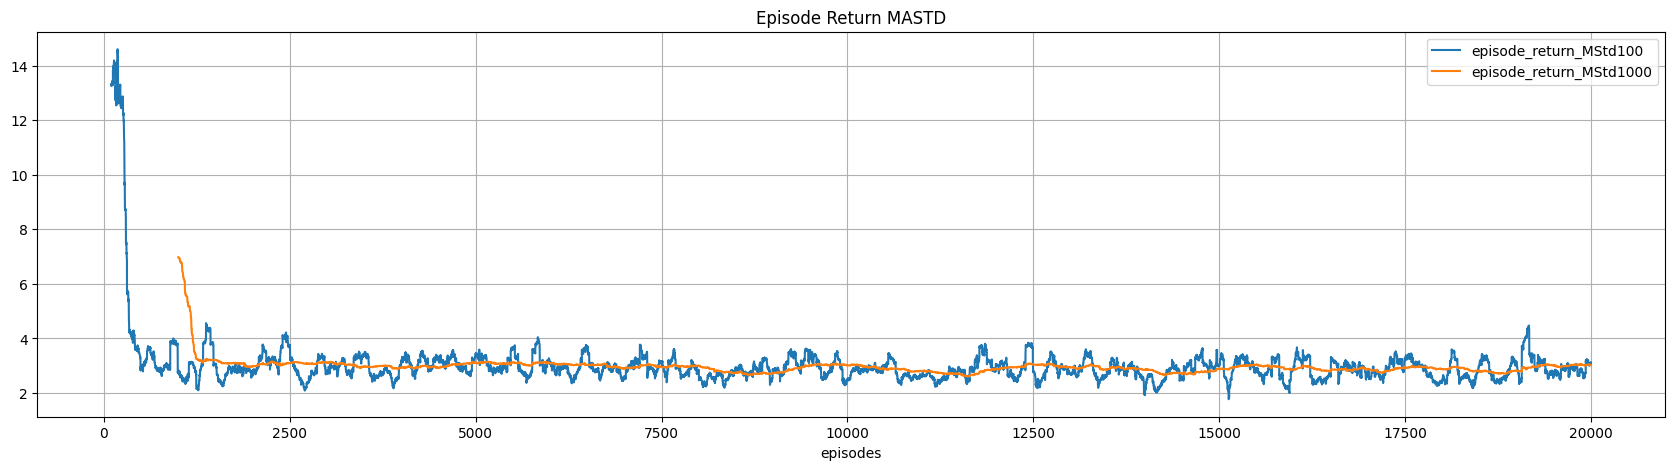

In [10]:
results_dir = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/results/spread=0.005_obj=var_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs'

train_log_df = pd.read_csv(results_dir + '/train_loop/logs.csv')
train_log_df['episode_return_MA100'] = train_log_df['episode_return'].rolling(window=100).mean()
train_log_df['episode_return_MA1000'] = train_log_df['episode_return'].rolling(window=1000).mean()

train_log_df['episode_return_MStd100'] = train_log_df['episode_return'].rolling(window=100).std()
train_log_df['episode_return_MStd1000'] = train_log_df['episode_return'].rolling(window=1000).std()

train_log_df.plot(x='episodes', y=['episode_return'], figsize=(21, 5), grid=True, title='Episode Return')
train_log_df.plot(x='episodes', y=['episode_return_MA100', 'episode_return_MA1000'], figsize=(21, 5), grid=True, title='Episode Return MA')
train_log_df.plot(x='episodes', y=['episode_return_MStd100', 'episode_return_MStd1000'], figsize=(21, 5), grid=True, title='Episode Return MASTD')

----------------------------------
## **Learner

b  critic_loss  policy_loss  steps     walltime
0      1.0     1.041948     0.000033      1     0.000000
1      1.0     0.964304     0.000029      2     0.050138
2      1.0     1.232208     0.000033      3     0.092800
3      1.0     0.875801     0.000028      4     0.136615
4      1.0     0.947897     0.000032      5     0.181909
...    ...          ...          ...    ...          ...
83662  1.0     0.516830     0.080841   8787  1620.769185
83663  1.0     0.549286     0.072930   8788  1621.008313
83664  1.0     0.543608     0.068319   8789  1621.213663
83665  1.0     0.491545     0.067448   8790  1621.412763
83666  1.0     0.498354     0.072420   8791  1621.615052

[83667 rows x 5 columns]

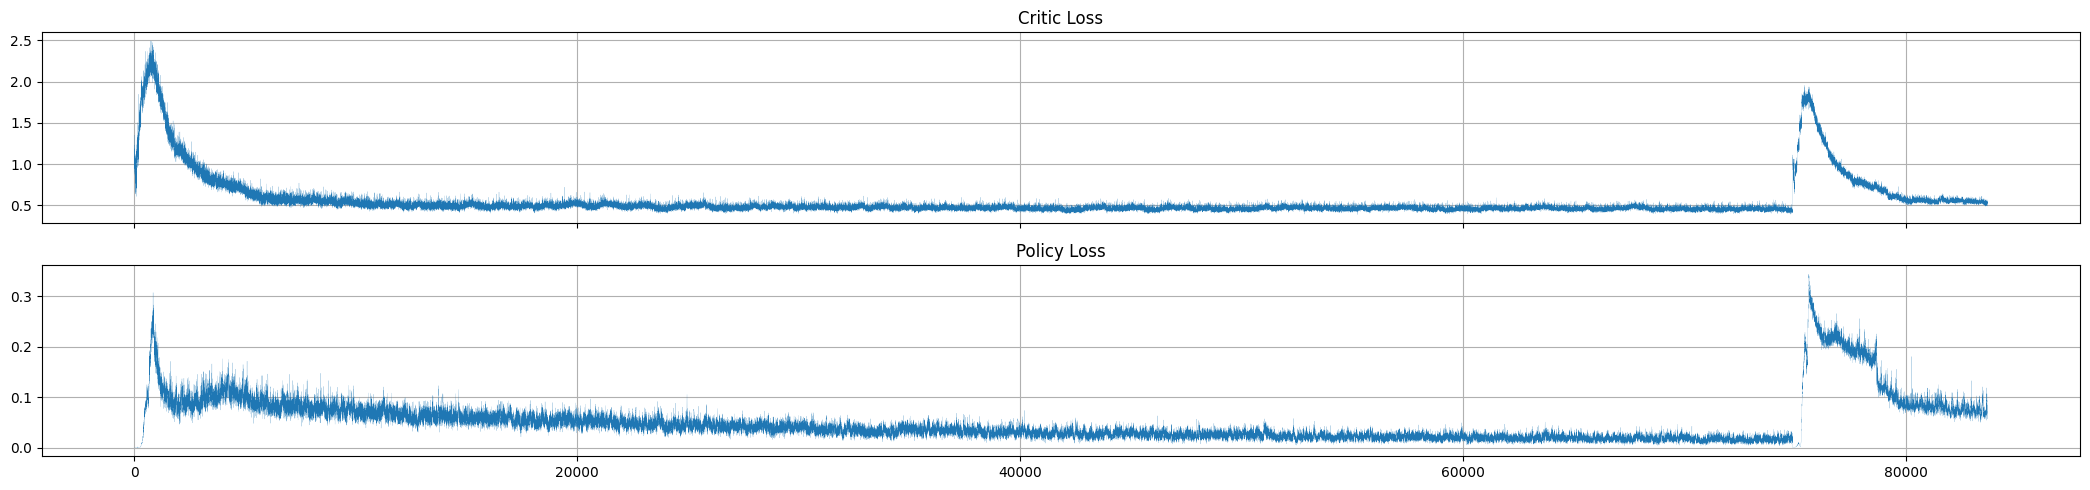

In [11]:
learner_log = '/home/alexanderithakis/gamma-vega-rl-hedging/logs/RL/Huber4/spread=0.005_obj=var_threshold=0.95_critic=qr-huber_v=0.0_hedttm=30/logs/learner/logs.csv'

learner_log_df = pd.read_csv(results_dir + '/learner/logs.csv')

fig, axs = plt.subplots(2, 1, figsize=(21, 15), sharex=True)#, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
learner_log_df.critic_loss.plot(figsize=(21, 5), grid=True, title='Critic Loss', linewidth=.1, ax=axs[0])
learner_log_df.policy_loss.plot(figsize=(21, 5), grid=True, title='Policy Loss', linewidth=.1, ax=axs[1])
plt.tight_layout()
learner_log_df

# train_log_df = pd.read_csv(train_log)
# train_log_df['episode_return_MA100'] = train_log_df['episode_return'].rolling(window=100).mean()
# train_log_df['episode_return_MA1000'] = train_log_df['episode_return'].rolling(window=1000).mean()
# train_log_df.plot(x='episodes', y=['episode_return'], figsize=(21, 5), grid=True, title='Episode Return')
# train_log_df.plot(x='episodes', y=['episode_return_MA100', 'episode_return_MA1000'], figsize=(21, 5), grid=True, title='Episode Return')

# **Section 1: Strategy P&L Analysis**

## **General Functions**

In [52]:
def generate_stat(folder, eval_quantiles, fig, agent_name):
  eval_df = pd.read_csv(folder)
  eval_loop_df = eval_df[['episode','step_pnl']].groupby('episode').aggregate('sum')
  eval_loop_df.columns = ['episode_return']
  gamma_exposure_df = eval_df[['episode','gamma_before_hedge', 'gamma_after_hedge']]
  gamma_exposure_df['gamma_hedged_amount'] = (gamma_exposure_df['gamma_before_hedge']-gamma_exposure_df['gamma_after_hedge'])*np.sign(gamma_exposure_df['gamma_before_hedge'])
  gamma_exposure_df['gamma_before_hedge_level'] = gamma_exposure_df['gamma_before_hedge'].abs()
  gamma_exposure_df = gamma_exposure_df.groupby('episode').aggregate('sum')
  gamma_exposure = gamma_exposure_df['gamma_hedged_amount']/gamma_exposure_df['gamma_before_hedge_level']

  vega_exposure_df = eval_df[['episode','vega_before_hedge', 'vega_after_hedge']]
  vega_exposure_df['vega_hedged_amount'] = (vega_exposure_df['vega_before_hedge']-vega_exposure_df['vega_after_hedge'])*np.sign(vega_exposure_df['vega_before_hedge'])
  vega_exposure_df['vega_before_hedge_level'] = vega_exposure_df['vega_before_hedge'].abs()
  vega_exposure_df = vega_exposure_df.groupby('episode').aggregate('sum')
  vega_exposure = vega_exposure_df['vega_hedged_amount']/vega_exposure_df['vega_before_hedge_level']

  stats_str = '{0: <20}'.format(agent_name) + ' pnl mean: {:.2f} | std: {:.6f} | Mean-SD: {:.2f} | gamma-ratio: {:5.2f}({:5.2f}/{:5.2f}) | vega-ratio: {:5.2f}({:5.2f}/{:5.2f}) '.format(
          eval_loop_df['episode_return'].mean(),
          eval_loop_df['episode_return'].std(),
          eval_loop_df['episode_return'].mean()-1.645*eval_loop_df['episode_return'].std(),
          gamma_exposure.mean(), gamma_exposure.quantile(0.10), gamma_exposure.quantile(0.90),
          vega_exposure.mean(), vega_exposure.quantile(0.10), vega_exposure.quantile(0.90))
  for q in eval_quantiles:
    stats_str += '| var{:.0f}: {:8.2f} '.format(
              100*q, eval_loop_df['episode_return'].quantile(1-q))
  for q in eval_quantiles:
    stats_str += '| cvar{:.0f}: {:8.2f} '.format(
              100*q, eval_loop_df.loc[eval_loop_df['episode_return']<=eval_loop_df['episode_return'].quantile(1-q),'episode_return'].mean())
      
  print(stats_str)
  fig.add_trace(go.Histogram(
      x=eval_loop_df.episode_return.values,
      histnorm='percent', name=f'{agent_name} Terminal P&L', opacity=0.75,
      nbinsx=150
  ))
  fig.show()
  return eval_loop_df.episode_return.values

## **Section 4 Table 1 (GBM)**

**0.5% Transaction Cost**

In [53]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
generate_stat(
       '/home/alexanderithakis/gamma-vega-rl-hedging/logs/RL/Huber2/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')

Mean-SD              pnl mean: -3.41 | std: 10.636618 | Mean-SD: -20.91 | gamma-ratio:  0.79( 0.60/ 1.02) | vega-ratio:  0.14( 0.04/ 0.28) | var95:   -19.66 | var85:   -11.76 | var75:    -8.70 | var65:    -5.84 | cvar95:   -30.24 | cvar85:   -20.23 | cvar75:   -16.25 | cvar65:   -13.68 


array([-4.44651665e+00,  5.23996421e+00, -6.10710293e+00,  3.49378838e+00,
       -1.04365010e+01, -1.42178170e+01,  9.57085279e+00, -1.45570561e+01,
        8.80855807e-04,  5.84850449e-01, -5.31124246e+00, -1.11924932e+01,
       -1.71639960e+01, -1.05760533e+01, -8.87590058e+00,  2.68049237e+01,
        7.84588936e+00,  8.18179230e+00, -2.68851839e+00, -3.26459863e+00,
       -1.27924273e+00, -5.13632858e+00,  5.96223767e+00, -4.61957117e+00,
       -5.19660001e+00, -1.37873343e+01, -2.20821541e+00, -1.09247541e+01,
        5.79101268e+00,  2.79925156e+01,  5.01434846e+00,  3.54020567e+00,
       -1.61754924e+01, -3.17082605e+01,  5.45644499e+00, -9.92418438e+00,
        1.21034417e+01, -7.22664728e+00, -1.46744062e+01,  5.02028504e+00,
       -1.11184637e+01, -5.71881433e+00, -5.50082090e+00,  1.22692391e+00,
       -1.06904939e+01,  8.99418029e+00, -4.15094505e+00, -1.04447445e+01,
       -1.17512456e+01,  2.01451077e+00, -1.93138302e+00,  5.67534819e+00,
       -5.25922990e-01, -

In [6]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')

generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC05/RL/mean_std/spread=0.005_obj=meanstd_threshold=0.95_critic=qr_v=0.0_hedttm=30/logs/eval_env/logs.csv'

**1% Transaction Cost**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC10/RL/mean_std/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.0_hedttm=30'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC10/RL/var/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.0_hedttm=30'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC10/RL/cvar/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.0_hedttm=30'
gkfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC10/Baseline/delta/greekhedge_spread=0.01_v=0.0_hedttm=30'
gkfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC10/Baseline/gamma/greekhedge_spread=0.01_v=0.0_hedttm=30'

In [7]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
rl_pnl = generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')

delta_pnl = generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
gamma_pnl = generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC05/RL/mean_std/spread=0.005_obj=meanstd_threshold=0.95_critic=qr_v=0.0_hedttm=30/logs/eval_env/logs.csv'

In [54]:
hist_data = [delta_pnl,gamma_pnl,rl_pnl]
group_labels = ['Delta-Neutral','Delta-Gamma-Neutral','RL']
fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
fig.update_layout(
  title_text='Terminal P&L Distribution (Spread=1%)', # title of plot
)
fig.show()

NameError: name 'delta_pnl' is not defined

**Transaction Cost 2%**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC20/RL/mean_std/spread=0.02_obj=meanstd_threshold=0.95_critic=qr_v=0.0_hedttm=30'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC20/RL/var/spread=0.02_obj=var_threshold=0.95_critic=qr_v=0.0_hedttm=30'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC20/RL/cvar/spread=0.02_obj=cvar_threshold=0.95_critic=qr_v=0.0_hedttm=30'
gkfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC20/Baseline/delta/greekhedge_spread=0.02_v=0.0_hedttm=30'
gkfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table1/TC20/Baseline/gamma/greekhedge_spread=0.02_v=0.0_hedttm=30'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')

generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')

Mean-SD              pnl mean: -5.91 | std: 4.147970 | Mean-SD: -12.73 | gamma-ratio:  0.30( 0.20/ 0.41) | vega-ratio:  0.08( 0.04/ 0.13) | var95:   -12.98 | var85:   -10.02 | var75:    -8.44 | var65:    -7.24 | cvar95:   -15.54 | cvar85:   -12.71 | cvar75:   -11.30 | cvar65:   -10.30 
VaR95                pnl mean: -5.15 | std: 4.543931 | Mean-SD: -12.62 | gamma-ratio:  0.24( 0.16/ 0.33) | vega-ratio:  0.07( 0.04/ 0.11) | var95:   -13.05 | var85:    -9.51 | var75:    -7.87 | var65:    -6.52 | cvar95:   -16.05 | cvar85:   -12.69 | cvar75:   -11.08 | cvar65:    -9.96 
CVaR95               pnl mean: -5.78 | std: 4.059144 | Mean-SD: -12.46 | gamma-ratio:  0.29( 0.22/ 0.36) | vega-ratio:  0.08( 0.04/ 0.12) | var95:   -12.86 | var85:    -9.80 | var75:    -8.16 | var65:    -6.99 | cvar95:   -15.37 | cvar85:   -12.47 | cvar75:   -11.04 | cvar65:   -10.05 
Delta                pnl mean: 0.05 | std: 14.987090 | Mean-SD: -24.61 | gamma-ratio:  0.00( 0.00/ 0.00) | vega-ratio:  0.00( 0.00/ 0.00) |

array([-12.11795693, -12.61868473, -12.63293532, ..., -12.01200063,
       -13.70497912, -10.68597609])

## **Section 4 Table 2 (SABR)**

**0.5% Transaction Cost**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/mean_std/spread=0.005_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/var/spread=0.005_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/cvar/spread=0.005_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=30'
gkfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/delta/greekhedge_spread=0.005_v=0.3_hedttm=30'
gkfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/gamma/greekhedge_spread=0.005_v=0.3_hedttm=30'
gkfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/vega/greekhedge_spread=0.005_v=0.3_hedttm=30'

workfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/mean_std/spread=0.005_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/var/spread=0.005_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/RL/cvar/spread=0.005_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
gkfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/delta/greekhedge_spread=0.005_v=0.3_hedttm=90'
gkfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/gamma/greekhedge_spread=0.005_v=0.3_hedttm=90'
gkfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC05/Baseline/vega/greekhedge_spread=0.005_v=0.3_hedttm=90'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
print("30 Days Result")
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder3}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')
print("90 Days Result")
rl_pnl = generate_stat(
       f'{workfolder4}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder5}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder6}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder4}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder5}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder6}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')

30 Days Result
Mean-SD              pnl mean: -2.75 | std: 9.123019 | Mean-SD: -17.76 | gamma-ratio:  0.53( 0.24/ 0.73) | vega-ratio:  0.17( 0.06/ 0.31) | var95:   -17.67 | var85:   -10.61 | var75:    -7.43 | var65:    -5.29 | cvar95:   -24.52 | cvar85:   -17.16 | cvar75:   -13.82 | cvar65:   -11.68 
VaR95                pnl mean: -3.25 | std: 9.970477 | Mean-SD: -19.65 | gamma-ratio:  0.61( 0.41/ 0.81) | vega-ratio:  0.18( 0.05/ 0.36) | var95:   -19.31 | var85:   -11.37 | var75:    -8.38 | var65:    -6.04 | cvar95:   -27.49 | cvar85:   -18.85 | cvar75:   -15.20 | cvar65:   -12.89 
CVaR95               pnl mean: -3.44 | std: 9.342895 | Mean-SD: -18.81 | gamma-ratio:  0.73( 0.48/ 0.98) | vega-ratio:  0.16( 0.04/ 0.30) | var95:   -19.19 | var85:   -11.49 | var75:    -8.32 | var65:    -6.07 | cvar95:   -26.06 | cvar85:   -18.37 | cvar75:   -14.92 | cvar65:   -12.69 
Delta                pnl mean: 0.22 | std: 21.871468 | Mean-SD: -35.76 | gamma-ratio:  0.00( 0.00/ 0.00) | vega-ratio: -0.00

array([ -7.61137308, -10.63379189,  -5.8192754 , ...,  -7.21480022,
        -5.37170242,  -3.84990464])

**1% Transaction Cost**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/mean_std/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/var/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/cvar/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=30'
gkfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/delta/greekhedge_spread=0.01_v=0.3_hedttm=30'
gkfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/gamma/greekhedge_spread=0.01_v=0.3_hedttm=30'
gkfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/vega/greekhedge_spread=0.01_v=0.3_hedttm=30'

workfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/mean_std/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/var/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/cvar/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
gkfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/delta/greekhedge_spread=0.01_v=0.3_hedttm=90'
gkfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/gamma/greekhedge_spread=0.01_v=0.3_hedttm=90'
gkfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/Baseline/vega/greekhedge_spread=0.01_v=0.3_hedttm=90'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
print("30 Days Result")
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder3}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')
print("90 Days Result")
rl_pnl = generate_stat(
       f'{workfolder4}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder5}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder6}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder4}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder5}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder6}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')

30 Days Result
Mean-SD              pnl mean: -4.40 | std: 9.502285 | Mean-SD: -20.03 | gamma-ratio:  0.50( 0.38/ 0.62) | vega-ratio:  0.13( 0.04/ 0.23) | var95:   -19.94 | var85:   -12.51 | var75:    -9.46 | var65:    -7.05 | cvar95:   -27.14 | cvar85:   -19.43 | cvar75:   -16.00 | cvar65:   -13.78 
VaR95                pnl mean: -3.98 | std: 10.085474 | Mean-SD: -20.57 | gamma-ratio:  0.45( 0.31/ 0.57) | vega-ratio:  0.12( 0.04/ 0.20) | var95:   -20.22 | var85:   -12.73 | var75:    -9.10 | var65:    -6.82 | cvar95:   -27.98 | cvar85:   -19.89 | cvar75:   -16.21 | cvar65:   -13.85 
CVaR95               pnl mean: -4.00 | std: 9.747739 | Mean-SD: -20.04 | gamma-ratio:  0.42( 0.29/ 0.56) | vega-ratio:  0.10( 0.04/ 0.18) | var95:   -20.26 | var85:   -12.75 | var75:    -9.40 | var65:    -6.85 | cvar95:   -26.81 | cvar85:   -19.65 | cvar75:   -16.18 | cvar65:   -13.86 
Delta                pnl mean: 0.22 | std: 21.871468 | Mean-SD: -35.76 | gamma-ratio:  0.00( 0.00/ 0.00) | vega-ratio: -0.0

array([-14.42323398, -16.58393544, -11.42405453, ..., -13.71335726,
       -11.02408419,  -9.83422746])

**Transaction Cost 2%**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/mean_std/spread=0.02_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/var/spread=0.02_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=30'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/cvar/spread=0.02_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=30'
gkfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/delta/greekhedge_spread=0.02_v=0.3_hedttm=30'
gkfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/gamma/greekhedge_spread=0.02_v=0.3_hedttm=30'
gkfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/vega/greekhedge_spread=0.02_v=0.3_hedttm=30'

workfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/mean_std/spread=0.02_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/var/spread=0.02_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/RL/cvar/spread=0.02_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
gkfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/delta/greekhedge_spread=0.02_v=0.3_hedttm=90'
gkfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/gamma/greekhedge_spread=0.02_v=0.3_hedttm=90'
gkfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC20/Baseline/vega/greekhedge_spread=0.02_v=0.3_hedttm=90'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
print("30 Days Result")
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder2}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder3}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')
print("90 Days Result")
rl_pnl = generate_stat(
       f'{workfolder4}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD')
generate_stat(
       f'{workfolder5}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95')
generate_stat(
       f'{workfolder6}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95')
generate_stat(
       f'{gkfolder4}/logs/eval_delta_env/logs.csv', 
       eval_quantiles, fig, 'Delta')
generate_stat( 
       f'{gkfolder5}/logs/eval_gamma_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Gamma')
generate_stat( 
       f'{gkfolder6}/logs/eval_vega_env/logs.csv', 
       eval_quantiles, fig, 'Delta-Vega')

30 Days Result
Mean-SD              pnl mean: -7.01 | std: 10.430630 | Mean-SD: -24.17 | gamma-ratio:  0.33( 0.21/ 0.47) | vega-ratio:  0.11( 0.04/ 0.19) | var95:   -24.08 | var85:   -16.57 | var75:   -12.70 | var65:    -9.79 | cvar95:   -31.95 | cvar85:   -23.85 | cvar75:   -20.09 | cvar65:   -17.54 
VaR95                pnl mean: -5.70 | std: 10.893821 | Mean-SD: -23.62 | gamma-ratio:  0.29( 0.17/ 0.41) | vega-ratio:  0.07( 0.03/ 0.12) | var95:   -23.85 | var85:   -15.65 | var75:   -11.65 | var65:    -8.78 | cvar95:   -31.65 | cvar85:   -23.30 | cvar75:   -19.41 | cvar65:   -16.76 
CVaR95               pnl mean: -5.62 | std: 11.046302 | Mean-SD: -23.79 | gamma-ratio:  0.27( 0.15/ 0.38) | vega-ratio:  0.07( 0.03/ 0.12) | var95:   -23.71 | var85:   -15.77 | var75:   -11.73 | var65:    -8.73 | cvar95:   -31.57 | cvar85:   -23.31 | cvar75:   -19.44 | cvar65:   -16.80 
Delta                pnl mean: 0.22 | std: 21.871468 | Mean-SD: -35.76 | gamma-ratio:  0.00( 0.00/ 0.00) | vega-ratio: -0

array([-28.04695577, -28.48422253, -22.63361279, ..., -26.71047135,
       -22.32884774, -21.80287309])

# **Section 5 Robustness Test Table 1**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.0_mean_std_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.0_var_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.0_cvar_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/mean_std/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/var/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/cvar/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder7 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.6_mean_std_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder8 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.6_var_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder9 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.6_cvar_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder10 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.15_mean_std_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder11 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.15_var_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder12 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.15_cvar_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder13 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.45_mean_std_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder14 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.45_var_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder15 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_1/TC10/RL/0.45_cvar_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.0')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.0')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.0')
generate_stat(
       f'{workfolder4}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.3')
generate_stat(
       f'{workfolder5}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.3')
generate_stat(
       f'{workfolder6}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.3')
generate_stat(
       f'{workfolder7}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.6')
generate_stat(
       f'{workfolder8}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.6')
generate_stat(
       f'{workfolder9}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.6')
generate_stat(
       f'{workfolder10}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.15')
generate_stat(
       f'{workfolder11}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.15')
generate_stat(
       f'{workfolder12}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.15')
generate_stat(
       f'{workfolder13}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.45')
generate_stat(
       f'{workfolder14}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.45')
generate_stat(
       f'{workfolder15}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.45')

Mean-SD - 0.0        pnl mean: -6.03 | std: 10.491876 | Mean-SD: -23.29 | gamma-ratio:  0.17( 0.09/ 0.26) | vega-ratio:  0.16( 0.07/ 0.26) | var95:   -24.38 | var85:   -16.03 | var75:   -11.84 | var65:    -8.90 | cvar95:   -31.04 | cvar85:   -23.31 | cvar75:   -19.52 | cvar65:   -16.89 
VaR95 - 0.0          pnl mean: -6.43 | std: 10.207762 | Mean-SD: -23.22 | gamma-ratio:  0.18( 0.12/ 0.26) | vega-ratio:  0.16( 0.06/ 0.26) | var95:   -23.96 | var85:   -16.07 | var75:   -12.04 | var65:    -9.29 | cvar95:   -30.71 | cvar85:   -23.09 | cvar75:   -19.40 | cvar65:   -16.88 
CVaR95 - 0.0         pnl mean: -7.08 | std: 10.810706 | Mean-SD: -24.86 | gamma-ratio:  0.21( 0.13/ 0.31) | vega-ratio:  0.17( 0.04/ 0.29) | var95:   -25.75 | var85:   -17.32 | var75:   -13.08 | var65:   -10.11 | cvar95:   -32.79 | cvar85:   -24.75 | cvar75:   -20.83 | cvar65:   -18.15 
Mean-SD - 0.3        pnl mean: -6.21 | std: 7.540365 | Mean-SD: -18.61 | gamma-ratio:  0.14( 0.06/ 0.23) | vega-ratio:  0.37( 0.28/ 0.46

array([ -6.10660623,  -3.70040197, -13.72185003, ..., -16.67600445,
        -2.92126885,   3.5872744 ])

# **Section 5 Robustness Test Table 2**

In [ ]:
workfolder = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.2_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder2 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.2_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder3 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.2_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder4 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/mean_std/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder5 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/var/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder6 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Table2/TC10/RL/cvar/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder7 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.4_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder8 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.4_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder9 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.4_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder10 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.25_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder11 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.25_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder12 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.25_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder13 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.35_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder14 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.35_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder15 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.35_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder16 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.1_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder17 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.1_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder18 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.1_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder19 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/mean_std/init_vol_0.5_eval/spread=0.01_obj=meanstd_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder20 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/var/init_vol_0.5_eval/spread=0.01_obj=var_threshold=0.95_critic=qr_v=0.3_hedttm=90'
workfolder21 = '/content/gdrive/MyDrive/FinHub/Gamma and Vega Hedging Using Deep Distributional Reinforcement Learning/gammahedging_paper_codebase/logs/batch14/Robustness_Table_2/TC10/RL/cvar/init_vol_0.5_eval/spread=0.01_obj=cvar_threshold=0.95_critic=qr_v=0.3_hedttm=90'

In [ ]:
eval_quantiles = [0.95, 0.85, 0.75,0.65]
fig = go.Figure()
rl_pnl = generate_stat(
       f'{workfolder}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.2')
generate_stat(
       f'{workfolder2}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.2')
generate_stat(
       f'{workfolder3}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.2')
generate_stat(
       f'{workfolder4}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.3')
generate_stat(
       f'{workfolder5}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.3')
generate_stat(
       f'{workfolder6}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.3')
generate_stat(
       f'{workfolder7}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.4')
generate_stat(
       f'{workfolder8}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.4')
generate_stat(
       f'{workfolder9}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.4')
generate_stat(
       f'{workfolder10}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.25')
generate_stat(
       f'{workfolder11}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.25')
generate_stat(
       f'{workfolder12}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.25')
generate_stat(
       f'{workfolder13}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.35')
generate_stat(
       f'{workfolder14}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.35')
generate_stat(
       f'{workfolder15}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.35')
generate_stat(
       f'{workfolder16}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.1')
generate_stat(
       f'{workfolder17}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.1')
generate_stat(
       f'{workfolder18}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.1')
generate_stat(
       f'{workfolder19}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'Mean-SD - 0.5')
generate_stat(
       f'{workfolder20}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'VaR95 - 0.5')
generate_stat(
       f'{workfolder21}/logs/eval_env/logs.csv',
       eval_quantiles, fig, 'CVaR95 - 0.5')

Mean-SD - 0.2        pnl mean: -8.94 | std: 7.621251 | Mean-SD: -21.48 | gamma-ratio:  0.21( 0.06/ 0.39) | vega-ratio:  0.50( 0.35/ 0.66) | var95:   -22.05 | var85:   -16.22 | var75:   -13.22 | var65:   -11.07 | cvar95:   -27.31 | cvar85:   -21.56 | cvar75:   -18.79 | cvar65:   -16.89 
VaR95 - 0.2          pnl mean: -8.37 | std: 7.298185 | Mean-SD: -20.37 | gamma-ratio:  0.22( 0.07/ 0.39) | vega-ratio:  0.53( 0.35/ 0.68) | var95:   -19.61 | var85:   -14.73 | var75:   -12.37 | var65:   -10.59 | cvar95:   -24.65 | cvar85:   -19.38 | cvar75:   -17.01 | cvar65:   -15.42 
CVaR95 - 0.2         pnl mean: -7.79 | std: 8.042086 | Mean-SD: -21.02 | gamma-ratio:  0.18( 0.05/ 0.33) | vega-ratio:  0.46( 0.26/ 0.67) | var95:   -21.27 | var85:   -14.88 | var75:   -11.95 | var65:   -10.02 | cvar95:   -27.07 | cvar85:   -20.65 | cvar75:   -17.72 | cvar65:   -15.77 
Mean-SD - 0.3        pnl mean: -6.21 | std: 7.540365 | Mean-SD: -18.61 | gamma-ratio:  0.14( 0.06/ 0.23) | vega-ratio:  0.37( 0.28/ 0.46) |

array([-10.05420826,  -3.81040234, -11.49048567, ..., -15.18543347,
        -8.45828324,   1.96351702])